In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

plt.rc('font', family='Malgun Gothic')  # 폰트 지정
plt.rc('axes', unicode_minus=False)  # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'  # 그래프 글씨 뚜렷

df_train = pd.read_csv("../data/df_train.csv")
df_test = pd.read_csv("../data/df_test.csv")

df_train['target'] = df_train['사망자수']*10 + df_train['중상자수']*5 + df_train['경상자수']*3 + df_train['부상자수']
df_train.drop(columns = ['사망자수','중상자수','경상자수','부상자수'], axis=1, inplace = True)

X = df_train.drop(columns = 'target',axis=1)
y = df_train['target']

x_train, x_test, y_train , y_test = train_test_split(X, y, test_size = 0.3, random_state=42 )

# tuner

In [33]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

In [34]:
def build_model(hp):

    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=[31]))

    for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
        model.add(layers.Dense(units=hp.Int(
            f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(layers.Dense(1))
        model.compile(optimizer='SGD', loss='mean_squared_error')
        return model

In [40]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5, # 시도할 하이퍼파라미터 조합 수
    executions_per_trial=3, # 각 조합에 대해 실행할 시도 횟수, 여러번 실행 후 가장 좋은 모델 선택
    directory= '\\tuner', # 튜닝 중간 결과를 저장할 디렉토리
    project_name='002Project'
)

Reloading Tuner from \tuner\002Project\tuner0.json


In [41]:
tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Trial 5 Complete [00h 00m 39s]
val_loss: 10.45837688446045

Best val_loss So Far: 10.450213432312012
Total elapsed time: 00h 02m 16s


In [42]:
# 가장 좋은 트라이얼(모델)을 얻기
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

In [43]:
best_trial.hyperparameters.values

{'num_layers': 1, 'units_0': 416}

# 학습

In [44]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(416, input_shape=[31], activation='relu'),
    tf.keras.layers.Dense(1)
])

In [45]:
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
    loss = tf.keras.losses.MeanAbsoluteError(),
    metrics = [
        tf.keras.metrics.MeanSquaredError()
    ]
)

In [46]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=10)

Epoch 1/10
867/867 [==============================] - 2s 2ms/step - loss: 2.0767 - mean_squared_error: 12.3510 - val_loss: 1.9858 - val_mean_squared_error: 12.7047
Epoch 2/10
867/867 [==============================] - 1s 1ms/step - loss: 2.0057 - mean_squared_error: 12.1725 - val_loss: 1.9852 - val_mean_squared_error: 12.9725
Epoch 3/10
867/867 [==============================] - 1s 2ms/step - loss: 2.0022 - mean_squared_error: 12.1002 - val_loss: 1.9879 - val_mean_squared_error: 12.9569
Epoch 4/10
867/867 [==============================] - 1s 1ms/step - loss: 2.0005 - mean_squared_error: 12.0730 - val_loss: 1.9814 - val_mean_squared_error: 12.4893
Epoch 5/10
867/867 [==============================] - 1s 2ms/step - loss: 1.9997 - mean_squared_error: 12.0144 - val_loss: 1.9851 - val_mean_squared_error: 12.3345
Epoch 6/10
867/867 [==============================] - 1s 2ms/step - loss: 1.9992 - mean_squared_error: 11.9276 - val_loss: 1.9787 - val_mean_squared_error: 12.5042
Epoch 7/10
867/8

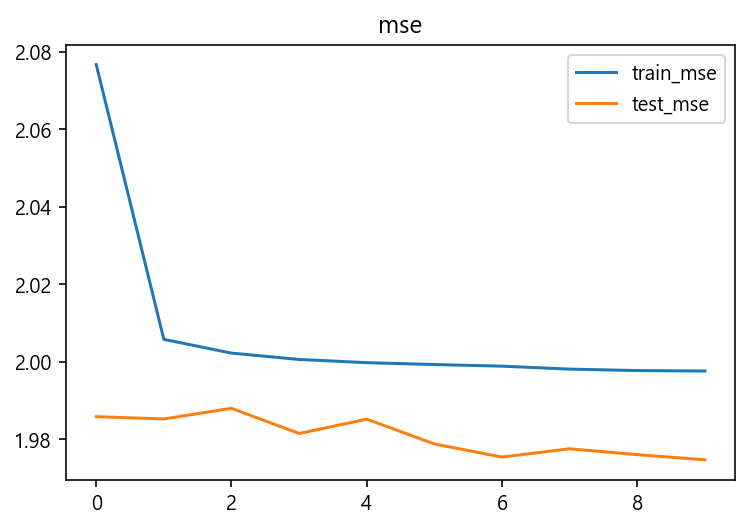

In [47]:
plt.plot(history.history['loss'], label='train_mse')
plt.plot(history.history['val_loss'], label='test_mse')
plt.title('mse')
plt.legend()
plt.show()

# 제출

In [48]:
model.save('../model/002_tuner_sgd-model.h5')

In [49]:
sub_file = pd.read_csv("../data/sample_submission.csv")

In [50]:
sub_file['ECLO'] = model.predict(df_test)
sub_file['ECLO'] = round(sub_file['ECLO'])

343/343 [==============================] - 0s 894us/step


In [54]:
sub_file.ECLO.value_counts()

3.0    7579
4.0    3172
5.0     193
2.0      19
Name: ECLO, dtype: int64

In [55]:
sub_file.to_csv("../data/sub_file/003tf_tuner_round.csv", index=False)